In [71]:
import tools as tools


# Standard imports 
import numpy as np
import pandas as pd
import geopandas as gpd

# Misc
from toolz import curry

# Latex tables
from stargazer.stargazer import Stargazer

# Plotting 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import statsmodels.formula.api as smf
from toolz import curry

# # plt.rc('font', size=10)             # controls default text sizes
# plt.rc('axes', titlesize=18)        # fontsize of the axes title
# plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
# plt.rc('xtick', labelsize=18)       # fontsize of the tick labels
# plt.rc('ytick', labelsize=18)       # fontsize of the tick labels
# plt.rc('legend', fontsize=14)       # legend fontsize
# plt.rc('figure', titlesize=20)      # fontsize of the figure title

plt.rcParams['figure.figsize'] = 11, 6 # set default size of plots

# Filter warnings 
pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\1115807330.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Header (state non-commercial/academic intentions)

In [72]:
header = {'name' : 'Jørgen Baun Høst',          'email' : 'pjz633@econ.ku.dk',
          'intention': 'Scrape Boliga for academic purposes'}

In [73]:
df=pd.read_parquet('data/boliga.pq')
df=df.sort_values('soldDate')
df['guid']=df['guid'].str.lower()
df['price_1000']=df['price']/1000
df=df[(df['year']>=2000) & (df['year']<=2010)]
df=df.reset_index(drop=True)
df['time_6m']=pd.PeriodIndex(df['soldDate'], freq='2Q')
df


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,city,groupKey,canGetVR,bfEnr,year,month,week,time_q,price_1000,time_6m
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,Aarhus V,NaN,True,4220221,2000,1,5,2000Q1,1495.000,2000Q1
1,0,Borthigsgade 26,6000,564680,2000-01-01 23:00:00+00:00,1,Alm. Salg,4826.3247,3.0,117,...,Kolding,NaN,True,5679177,2000,1,5,2000Q1,564.680,2000Q1
2,0,Horsekilden 17,4000,1251000,2000-01-01 23:00:00+00:00,1,Alm. Salg,10170.7310,4.0,123,...,Roskilde,NaN,True,1304154,2000,1,5,2000Q1,1251.000,2000Q1
3,0,Skovbakkevej 99,8800,370000,2000-01-01 23:00:00+00:00,1,Alm. Salg,2356.6880,6.0,157,...,Viborg,NaN,True,8459754,2000,1,5,2000Q1,370.000,2000Q1
4,0,Præstebakken 15,2610,1458444,2000-01-01 23:00:00+00:00,1,Alm. Salg,7596.0625,7.0,192,...,Rødovre,NaN,True,2041293,2000,1,5,2000Q1,1458.444,2000Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502012,0,Lillevangsvej 6,4174,1500000,2010-12-31 23:00:00+00:00,1,Alm. Salg,12000.0000,5.0,125,...,Jystrup Midtsj,NaN,True,2496794,2010,12,4,2010Q4,1500.000,2010Q4
502013,0,Ludvig Holsteins Alle 17,2750,1675000,2010-12-31 23:00:00+00:00,1,Alm. Salg,10029.9400,5.0,147,...,Ballerup,NaN,True,2108731,2010,12,4,2010Q4,1675.000,2010Q4
502014,0,Østerbyvej 9,9990,3000000,2010-12-31 23:00:00+00:00,1,Alm. Salg,15873.0160,6.0,189,...,Skagen,NaN,True,5530559,2010,12,4,2010Q4,3000.000,2010Q4
502015,526788,Engparken 37,6740,1125000,2010-12-31 23:00:00+00:00,1,Alm. Salg,10416.6670,4.0,108,...,Bramming,NaN,True,5047083,2010,12,4,2010Q4,1125.000,2010Q4


In [74]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,groupKey,canGetVR,bfEnr,year,month,week,time_q,price_1000,time_6m,geometry
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,NaN,True,4220221,2000,1,5,2000Q1,1495.000,2000Q1,POINT (10.16913 56.16901)
1,0,Borthigsgade 26,6000,564680,2000-01-01 23:00:00+00:00,1,Alm. Salg,4826.3247,3.0,117,...,NaN,True,5679177,2000,1,5,2000Q1,564.680,2000Q1,POINT (9.47292 55.48263)
2,0,Horsekilden 17,4000,1251000,2000-01-01 23:00:00+00:00,1,Alm. Salg,10170.7310,4.0,123,...,NaN,True,1304154,2000,1,5,2000Q1,1251.000,2000Q1,POINT (12.02684 55.63139)
3,0,Skovbakkevej 99,8800,370000,2000-01-01 23:00:00+00:00,1,Alm. Salg,2356.6880,6.0,157,...,NaN,True,8459754,2000,1,5,2000Q1,370.000,2000Q1,POINT (9.43825 56.47037)
4,0,Præstebakken 15,2610,1458444,2000-01-01 23:00:00+00:00,1,Alm. Salg,7596.0625,7.0,192,...,NaN,True,2041293,2000,1,5,2000Q1,1458.444,2000Q1,POINT (12.46182 55.67929)


In [75]:
kommune_2006 = gpd.read_file('data/kommune_2006.shp')
kommune_2006

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,24842.0,Københavns Kommune,120727.0,2002-12-31,2006-12-31,64.0,Kommune,154225.005507,9.028113e+07,"MULTIPOLYGON Z (((12.73424 55.70328 0.00000, 1..."
1,24843.0,Frederiksberg Kommune,120728.0,1970-04-01,2006-12-31,64.0,Kommune,13520.324243,8.709197e+06,"POLYGON Z ((12.53736 55.69661 0.00000, 12.5370..."
2,46149.0,Birkerød Kommune,120748.0,1974-01-04,2006-12-31,64.0,Kommune,35777.227097,3.366869e+07,"POLYGON Z ((12.45040 55.81888 0.00000, 12.4473..."
3,46165.0,Græsted-Gilleleje Kommune,120753.0,1972-10-01,2006-12-31,64.0,Kommune,67562.933801,1.341441e+08,"POLYGON Z ((12.39490 56.03226 0.00000, 12.3952..."
4,46190.0,Jægerspris Kommune,120759.0,1975-01-01,2006-12-31,64.0,Kommune,84485.880031,9.514108e+07,"MULTIPOLYGON Z (((11.92257 55.90000 0.00000, 1..."
...,...,...,...,...,...,...,...,...,...,...
266,46773.0,Thyborøn-Harboøre Kommune,120920.0,2002-12-31,2006-12-31,64.0,Kommune,95733.805758,3.953641e+07,"MULTIPOLYGON Z (((8.18948 56.59492 0.00000, 8...."
267,46789.0,Vinderup Kommune,120925.0,2002-12-31,2006-12-31,64.0,Kommune,109305.320681,2.175008e+08,"MULTIPOLYGON Z (((8.85937 56.39892 0.00000, 8...."
268,46793.0,Åskov Kommune,120926.0,2001-12-31,2006-12-31,64.0,Kommune,77105.236905,2.388402e+08,"POLYGON Z ((8.86526 55.89540 0.00000, 8.86505 ..."
269,46804.0,Galten Kommune,120928.0,2001-12-31,2006-12-31,64.0,Kommune,54492.128242,7.268604e+07,"POLYGON Z ((9.95809 56.13030 0.00000, 9.96044 ..."


In [76]:
regioner=gpd.read_file('data/regioner.shp')
regioner

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,105612.0,Region Hovedstaden,118711.0,2007-01-01,9999-12-31,66.0,Region,7.371152e+05,2.563160e+09,"MULTIPOLYGON Z (((15.19733 55.31846 0.00000, 1..."
1,105615.0,Region Sjælland,118712.0,2011-11-27,9999-12-31,66.0,Region,2.196684e+06,7.216493e+09,"MULTIPOLYGON Z (((12.54857 54.95316 0.00000, 1..."
2,105616.0,Region Syddanmark,118713.0,2007-01-01,9999-12-31,66.0,Region,2.436420e+06,1.209603e+10,"MULTIPOLYGON Z (((10.68129 54.72772 0.00000, 1..."
3,105620.0,Region Midtjylland,118715.0,2011-01-01,9999-12-31,66.0,Region,2.564054e+06,1.299856e+10,"MULTIPOLYGON Z (((11.67150 56.73861 0.00000, 1..."
4,105617.0,Region Nordjylland,118714.0,2007-01-01,9999-12-31,66.0,Region,1.697705e+06,7.870127e+09,"MULTIPOLYGON Z (((10.98412 57.21880 0.00000, 1..."


In [77]:
gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
cols_to_drop=['index_right',
 'objectid',
 'navn',
 'enhedid',
 'fra',
 'til',
 'enhedtype',
 'art',
 'SHAPE_Leng',
 'SHAPE_Area']
gdf_merge['kommune_old']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')
gdf_merge['region']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge

C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\4171787026.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\4171787026.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,bfEnr,year,month,week,time_q,price_1000,time_6m,geometry,kommune_old,region
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,4220221,2000,1,5,2000Q1,1495.00,2000Q1,POINT (10.16913 56.16901),Århus Kommune,Region Midtjylland
23,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,4230330,2000,1,5,2000Q1,1887.74,2000Q1,POINT (10.22040 56.20569),Århus Kommune,Region Midtjylland
32,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,5629660,2000,1,6,2000Q1,1576.50,2000Q1,POINT (10.21504 56.17655),Århus Kommune,Region Midtjylland
39,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,4209569,2000,1,6,2000Q1,875.00,2000Q1,POINT (10.15009 56.25355),Århus Kommune,Region Midtjylland
42,0,Skæring Havvej 31,8250,1566000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7492.8228,6.0,209,...,4144887,2000,1,6,2000Q1,1566.00,2000Q1,POINT (10.30097 56.23074),Århus Kommune,Region Midtjylland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494929,0,Pilealle 2,9940,455250,2010-10-03 22:00:00+00:00,1,Alm. Salg,2975.4902,3.0,153,...,3252566,2010,10,6,2010Q4,455.25,2010Q4,POINT (11.01158 57.26166),Læsø Kommune,Region Nordjylland
496181,480732,Poppelvej 6,9940,1025000,2010-10-18 22:00:00+00:00,1,Alm. Salg,8760.6840,3.0,117,...,3253384,2010,10,0,2010Q4,1025.00,2010Q4,POINT (10.99848 57.25744),Læsø Kommune,Region Nordjylland
498194,453277,Lærkevej 1,9940,550000,2010-11-10 23:00:00+00:00,1,Alm. Salg,5670.1030,3.0,97,...,3256844,2010,11,2,2010Q4,550.00,2010Q4,POINT (10.92411 57.29236),Læsø Kommune,Region Nordjylland
498720,0,Tørkerivej 8,9940,750000,2010-11-16 23:00:00+00:00,1,Alm. Salg,4335.2603,5.0,173,...,3253936,2010,11,1,2010Q4,750.00,2010Q4,POINT (10.96635 57.25416),Læsø Kommune,Region Nordjylland


In [78]:
house_price_index = pd.read_excel('data/house_price_index.xlsx')
house_price_index['time_q']=pd.PeriodIndex(house_price_index['time_q'], freq='Q')
house_price_index

,region,time_q,house_price_index
0,Region Hovedstaden,1996Q1,0.296
1,Region Hovedstaden,1996Q2,0.304
2,Region Hovedstaden,1996Q3,0.314
3,Region Hovedstaden,1996Q4,0.328
4,Region Hovedstaden,1997Q1,0.325
...,...,...,...
395,Region Nordjylland,2014Q4,1.009
396,Region Nordjylland,2015Q1,1.048
397,Region Nordjylland,2015Q2,1.059
398,Region Nordjylland,2015Q3,1.053


In [79]:
land_taxes = pd.read_excel('data/kmn_grundskyldspromille.xlsx', sheet_name='Sheet2')
land_taxes

,kommune_amt_2006,kommune_sund_2007,kommune_grundskyld2006,kommune_grundskyld2007,delta_tax,delta_tax_service,kommune_old
0,"32,10","32,00","34,00","34,00",0.00,-0.10,Københavns Kommune
1,"31,20","31,20","27,00","27,00",0.00,0.00,Frederiksberg Kommune
2,"32,80","33,58","28,00","28,89",0.89,0.78,Ballerup-Måløv Kommune
3,"32,40","32,47","19,00","19,00",0.00,0.07,Brøndbyøster-Brøndbyvester Kommune
4,"32,60","32,81","25,70","25,70",0.00,0.21,Dragør Kommune
...,...,...,...,...,...,...,...
262,"32,60","33,13","22,00","24,14",2.14,0.53,Støvring Kommune
263,"33,10","32,66","24,00","26,22",2.22,-0.44,Sæby Kommune
264,"33,00","32,70","22,00","24,82",2.82,-0.30,Åbybro Kommune
265,"33,40","33,37","27,00","26,95",-0.05,-0.03,Ålborg Kommune


In [80]:
property_evals_01=pd.read_parquet('data/bbr_eval2001.pq')
property_evals_07=pd.read_parquet('data/bbr_eval2007.pq')
print(property_evals_01.head())
print(property_evals_07.head())

                                   guid  eval_prop_2001  eval_land_2001  \
0  2fbd9776-15f5-40d3-bb95-32aba20b730b         2600000          703700   
1  665bdc04-2e15-4e27-8367-c7fb4e8906af         2450000          760300   
2  914d602b-e33c-467d-887c-99b036bb377e          800000          141400   
3  8f4b2d05-140c-4d0e-ad52-7a9b2cc91aee          870000          145300   
4  1e0fee11-4170-408b-bff9-43f0be8857df          870000          145300   

  eval2001_last_changed  eval_year  
0            2022-03-28       2001  
1            2022-01-14       2001  
2            2021-10-25       2001  
3            2021-09-08       2001  
4            2021-09-08       2001  
                                   guid  eval_prop_2007  eval_land_2007  \
0  a5b48f17-1d82-43eb-a836-ef96c21d76e9         2550000          587200   
1  1efe6c1e-049b-422b-8ebf-c2b55ed20503         3250000          494500   
2  d9e79558-0edb-4b8e-bb6b-80408a9c606f          940000          359500   
3  4d914a60-5f57-433c-9483-

In [81]:
lot_sizes = pd.read_parquet('data/bbr_lotsize.pq')
lot_sizes

,guid,lot_size
0,4f53331c-22c9-4205-9461-27ea1d70e5d9,3479
1,fe3c7851-8ed5-4a34-b37b-7f9c9a5c8651,1205
2,664e5839-f106-4fe3-b996-b7e22c36a6e3,704
3,ddc85eb9-d4a9-4b81-b68a-bcf30351b5c6,1623
4,5b13820b-5fbc-42f9-9333-7fecc473ef2b,639
...,...,...
519591,6382cf23-613a-4d95-9fb0-b49611b2efc8,900
519592,005ac5ce-d978-4df4-a470-7b81fdc59641,366
519593,fd9ef5d3-5f58-447d-a625-31344a8f345d,776
519594,67b96c26-cd54-4c5e-8a2d-1e785e353db5,662


Merge landtaxes, house price index, bbr evaluations & lot size info

In [82]:
df_merged = pd.DataFrame(gdf_merge)
df_merged_index = pd.merge(df_merged, house_price_index, left_on=['time_q', 'region'], right_on=['time_q', 'region'])
df_merged_index = pd.merge(df_merged_index, land_taxes, left_on=['kommune_old'], right_on=['kommune_old'])
df_merged_index = pd.merge(df_merged_index, property_evals_01, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, property_evals_07, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, lot_sizes, left_on=['guid'], right_on=['guid'])
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


Keeping non-zero observations

In [83]:
df_merged_index=df_merged_index[df_merged_index['lot_size']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2001']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2007']!=0]
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


## Make map of tax changes

In [84]:
kommune_2006=kommune_2006.rename(columns={'navn': 'kommune_old'})

In [85]:
kommune_2006=kommune_2006.merge(land_taxes, on='kommune_old')

In [86]:
from matplotlib import colors
kommune_2006


mycmap = colors.ListedColormap(['midnightblue','mediumblue','blue','cyan','red','orangered','darkred'])
norm = colors.Normalize(kommune_2006.delta_tax.min(), kommune_2006.delta_tax.max())

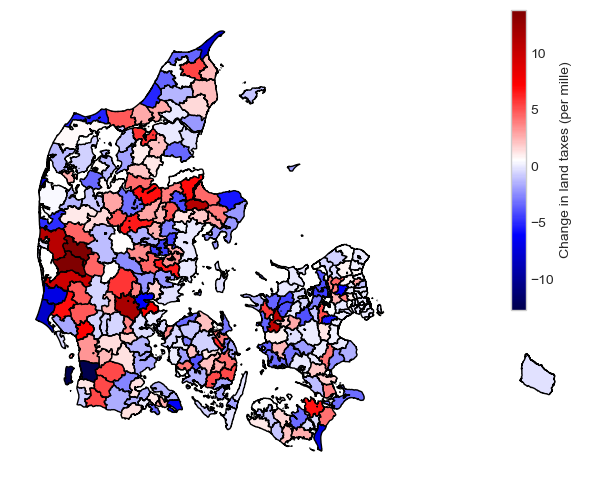

In [87]:
fig, ax = plt.subplots(1, 1)
kommune_2006.plot(column='delta_tax',
           ax=ax,
           cmap='seismic',
           norm=norm,
           legend=True,
           legend_kwds={'label': "Change in land taxes (per mille)",
                        'orientation': "vertical",
                        "shrink":.65,
                        'anchor': (-1, 1)},
            edgecolor='k')
ax.set_axis_off()   
fig.savefig('figs/fig_map_taxes.pdf', bbox_inches = "tight")

# Adding important variables

In [88]:
df_merged_index['real_price']=df_merged_index['price']/df_merged_index['house_price_index']
df_merged_index['real_sqmPrice']=df_merged_index['sqmPrice']/df_merged_index['house_price_index']
df_merged_index['ln_prop_value']=np.log(df_merged_index['eval_prop_2001'])
df_merged_index['ln_price']=np.log(df_merged_index['price'])
df_merged_index['ln_real_price']=np.log(df_merged_index['real_price'])
df_merged_index['delta_tax_eff']=(df_merged_index['delta_tax']*df_merged_index['eval_land_2007']/df_merged_index['eval_prop_2007'])
df_merged_index['delta_tax_service']

0         0.10
1         0.10
2         0.10
3         0.10
4         0.10
          ... 
482047   -0.77
482048   -0.77
482049   -0.77
482050   -0.77
482051   -0.77
Name: delta_tax_service, Length: 480638, dtype: float64

Categorize data by changes to land taxes

In [89]:
def land_tax_change07(value):
    if value > 0:
        return "Higher"
    elif value < 0:
        return "Lower"
    else:
        return "Unchanged"
df_merged_index['tax_change_reform'] = df_merged_index.apply(lambda row: land_tax_change07(row['delta_tax']), axis = 1)
df_merged_index['tax_change_reform']=df_merged_index['tax_change_reform'].astype('category')

# How many areas changed land taxes and how many did not?

In [90]:
df_merged_index.groupby('tax_change_reform')['kommune_old'].nunique()

tax_change_reform
Higher       132
Lower        110
Unchanged     24
Name: kommune_old, dtype: int64

In [91]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [92]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [93]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].min()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Allerød Kommune,0.02
Lower,Augustenborg Kommune,-12.76
Unchanged,Brøndbyøster-Brøndbyvester Kommune,0.00


In [105]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()

C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\2888431242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()


,delta_tax_eff
tax_change_reform,
Higher,0.670389
Lower,-0.453174
Unchanged,NaN


In [106]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()

C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\491435750.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()


,delta_tax_eff
tax_change_reform,
Higher,0.734330
Lower,0.524529
Unchanged,NaN


In [107]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].mean()

0.06776276948694683

In [108]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].std()

0.8435127738484179

In [94]:
df_merged_index=df_merged_index[df_merged_index['tax_change_reform']!="Unchanged"]

C:\Users\JBH\AppData\Local\Temp\ipykernel_10588\723349955.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()


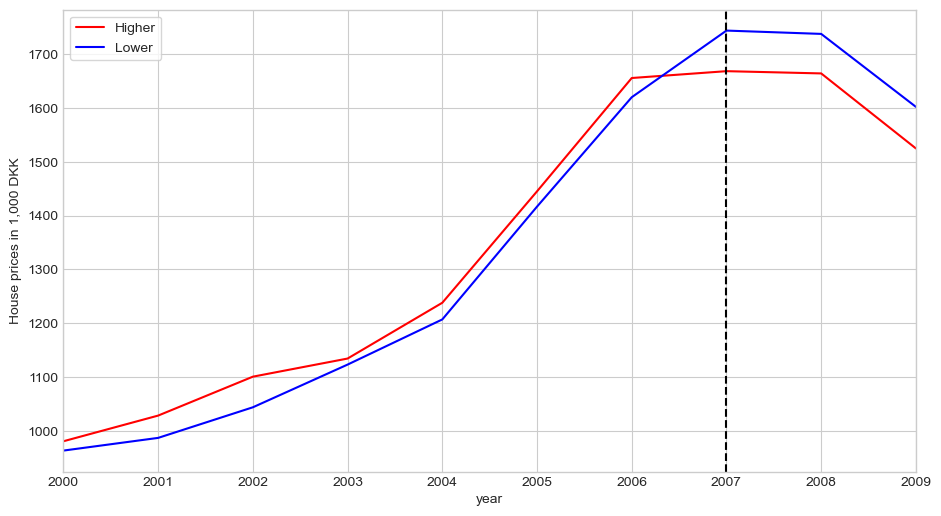

In [97]:
temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()
temp_agg_high_low = temp_agg.unstack()
plot=temp_agg_high_low['price_1000'][['Higher', 'Lower']].plot(color=['r', 'b'])
plot.axvline(x=2007,color='k', linestyle='--')
plot.set_xlim(2000, 2009)
plot.legend(frameon=True)
plot.set_xticks(np.arange(df_merged_index['year'].min(), df_merged_index['year'].max(), 1))
plt.ylabel('House prices in 1,000 DKK')

plt.savefig('figs/fig_house_price_trends.pdf', bbox_inches='tight')

In [26]:
df_merged_index=df_merged_index[df_merged_index['year']<=2008]
df_merged_index = df_merged_index.reset_index(drop=True)

In [27]:
stata_out = df_merged_index[['guid','ln_price', 'ln_real_price', 'kommune_old', 'year', 'ln_prop_value', 'delta_tax_eff']]
stata_out

,guid,ln_price,ln_real_price,kommune_old,year,ln_prop_value,delta_tax_eff
0,ca3266d1-c611-4ad0-bda7-0c15789b3544,14.217637,14.716863,Århus Kommune,2000,14.285514,-0.005247
1,ca3266d1-c611-4ad0-bda7-0c15789b3544,14.834358,14.830366,Århus Kommune,2006,14.285514,-0.005247
2,ba260035-a87d-4cf5-83be-e3331aff2f69,14.450891,14.950117,Århus Kommune,2000,14.346139,-0.007306
3,a3512da8-bb3b-40e2-bdd6-1db688c5ff71,14.270718,14.769944,Århus Kommune,2000,14.403297,-0.005855
4,a61c5c9c-50fd-4e79-b8cb-a8d4e8102f3a,13.681979,14.181206,Århus Kommune,2000,13.676248,-0.007017
...,...,...,...,...,...,...,...
374890,19505a16-5e1f-4e33-b3dc-6ed1a8c1e268,12.765688,12.674934,Læsø Kommune,2008,13.038982,-0.278191
374891,2242ac31-6f8c-44f2-bcb4-3c4e3321b49f,13.541074,13.450319,Læsø Kommune,2008,12.429216,-0.326700
374892,9f70444f-2e7c-4709-b3ac-454bdc24be93,14.220976,14.130221,Læsø Kommune,2008,13.270783,-0.230674
374893,623f1899-acc0-4d86-99fa-cf0d4e457d74,13.592367,13.549308,Læsø Kommune,2008,13.081541,-0.188010


In [28]:
stata_out['kommune_old_id']=stata_out.groupby('kommune_old').ngroup()
stata_out['id']=stata_out.groupby('guid').ngroup()

In [29]:
stata_out.to_stata('data/house.dta')

In [30]:
df_merged_index['year'].describe()

count    374895.000000
mean       2003.859126
std           2.515858
min        2000.000000
25%        2002.000000
50%        2004.000000
75%        2006.000000
max        2008.000000
Name: year, dtype: float64

In [31]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("kommune_old")[col_to_demean].transform("mean"))
                                        - df.groupby("year")[col_to_demean].transform("mean")})

In [32]:
years = [2004, 2005, 2006, 2007, 2008]


for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_merged_index[var_name]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_eff']
    var_name2 = f'year{year}_delta_tax_service'
    df_merged_index[var_name2]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_service']

In [33]:
df_merged_index['year2007_delta_tax_service']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
374890   -0.0
374891   -0.0
374892   -0.0
374893   -0.0
374894   -0.0
Name: year2007_delta_tax_service, Length: 374895, dtype: float64

In [34]:
formula = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""
mod_ols_fe = smf.ols(formula,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value")))
res_ols_fe=mod_ols_fe.fit(cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']}, fe=True)
res_ols_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_real_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     1242.
Date:                Fri, 28 Apr 2023   Prob (F-statistic):          9.08e-170
Time:                        10:53:40   Log-Likelihood:            -2.3927e+05
No. Observations:              374895   AIC:                         4.785e+05
Df Residuals:                  374889   BIC:                         4.786e+05
Df Model:                           5                                         
Covariance Type:              cluster                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4.8339      0.118    -41.133      0.000      -5.064      -4.604
year2005_delta_tax_eff    -0.0142      0.006     -2.578      0.010      -0.025      -0.003
year2006_delta_tax_eff    -0.0254      0.007     -3.726      0.000      -0.039      -0.012
year2007_delta_tax_eff    -0.0302      0.008     -3.899      0.000      -0.045      -0.015
year2008_delta_tax_eff    -0.0155      0.006     -2.524      0.012      -0.027      -0.003
ln_prop_value              0.6797      0.009     78.628      0.000       0.663       0.697
==============================================================================
Omnibus:                   223912.018   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8296715.282
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      25.586   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Conditional quantiles, fixed effects equal across quantiles

In [35]:
mod_quantile_fe_across = smf.quantreg(formula,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="delta_tax_service")))
result_quantile=mod_quantile_fe_across.fit(q=0.5,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
result_quantile.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          ln_real_price   Pseudo R-squared:               0.3374
Model:                       QuantReg   Bandwidth:                     0.01475
Method:                 Least Squares   Sparsity:                       0.5108
Date:                Fri, 28 Apr 2023   No. Observations:               374895
Time:                        10:53:44   Df Residuals:                   374889
                                        Df Model:                            5
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.2410      0.011   -202.041      0.000      -2.263      -2.219
year2005_delta_tax_eff    -0.0185      0.002    -11.975      0.000      -0.021      -0.015
year2006_delta_tax_eff    -0.0238      0.002    -14.759      0.000      -0.027      -0.021
year2007_delta_tax_eff    -0.0274      0.002    -17.040      0.000      -0.031      -0.024
year2008_delta_tax_eff    -0.0193      0.002    -10.540      0.000      -0.023      -0.016
ln_prop_value              0.8680      0.001   1064.610      0.000       0.866       0.870
==========================================================================================
"""

In [36]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)


def fit_model(q, sig_level=0.05):
    result_quantile = mod_quantile_fe_across.fit(q=q, cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    return [q, result_quantile.params["year2007_delta_tax_eff"]] + result_quantile.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()


models_fe_across = [fit_model(x) for x in quantiles]
models_fe_across = pd.DataFrame(models_fe_across, columns=["q", "year2007_delta_tax_eff", "lb", "ub"])

In [37]:
models_fe_across

,q,year2007_delta_tax_eff,lb,ub
0,0.1,-0.017370,-0.032008,-0.002733
1,0.2,-0.021771,-0.027297,-0.016245
2,0.3,-0.024197,-0.028006,-0.020389
3,0.4,-0.025889,-0.029184,-0.022593
4,0.5,-0.027360,-0.030507,-0.024213
5,0.6,-0.028673,-0.031928,-0.025417
6,0.7,-0.029389,-0.033131,-0.025647
7,0.8,-0.030794,-0.035701,-0.025886
8,0.9,-0.039954,-0.048610,-0.031297


array([-0.05      , -0.05102041, -0.05204082, -0.05306122, -0.05408163,
       -0.05510204, -0.05612245, -0.05714286, -0.05816327, -0.05918367,
       -0.06020408, -0.06122449, -0.0622449 , -0.06326531, -0.06428571,
       -0.06530612, -0.06632653, -0.06734694, -0.06836735, -0.06938776,
       -0.07040816, -0.07142857, -0.07244898, -0.07346939, -0.0744898 ,
       -0.0755102 , -0.07653061, -0.07755102, -0.07857143, -0.07959184,
       -0.08061224, -0.08163265, -0.08265306, -0.08367347, -0.08469388,
       -0.08571429, -0.08673469, -0.0877551 , -0.08877551, -0.08979592,
       -0.09081633, -0.09183673, -0.09285714, -0.09387755, -0.09489796,
       -0.09591837, -0.09693878, -0.09795918, -0.09897959, -0.1       ])

In [38]:
ols_fe_ci = res_ols_fe.conf_int(alpha=0.1).loc['year2007_delta_tax_eff'].to_list()
ols_fe_ci

[-0.042935700587221515, -0.017457584810956408]

In [39]:
ols_fe_dict=dict(param=res_ols_fe.params['year2007_delta_tax_eff'], lb=ols_fe_ci[0], ub=ols_fe_ci[1])
ols_fe_dict

{'param': -0.03019664269908896,
 'lb': -0.042935700587221515,
 'ub': -0.017457584810956408}

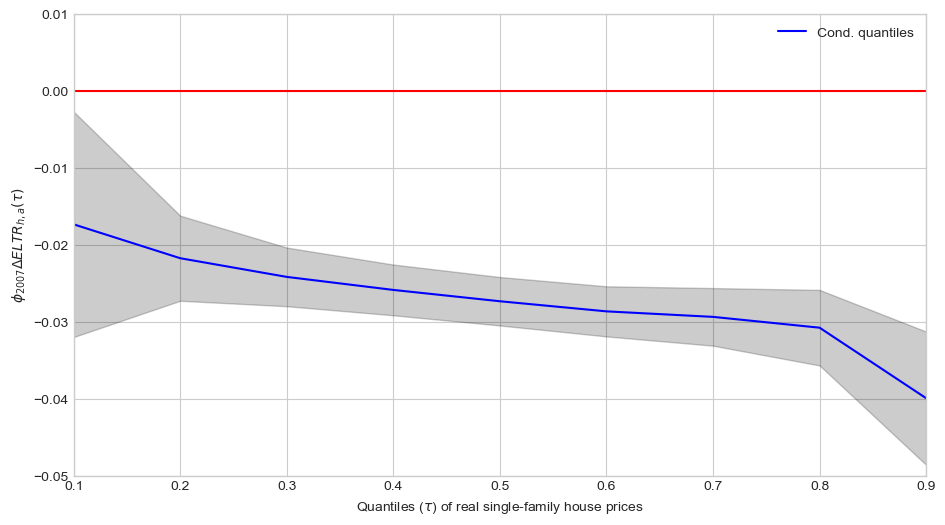

In [40]:
param_name = r'$\phi_{2007} \Delta E L T R_{h, a}(\tau)$'

n = models_fe_across.shape[0]
p1 = plt.plot(models_fe_across.q, models_fe_across.year2007_delta_tax_eff, color="blue", label="Cond. quantiles")
plt.fill_between(models_fe_across.q, models_fe_across.ub, models_fe_across.lb, alpha=0.2, color="black")
# p4 = plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
# plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.05, 0.01)
plt.legend()
plt.savefig('figs/fig_quant_reg_res.pdf', bbox_inches='tight')
plt.show()

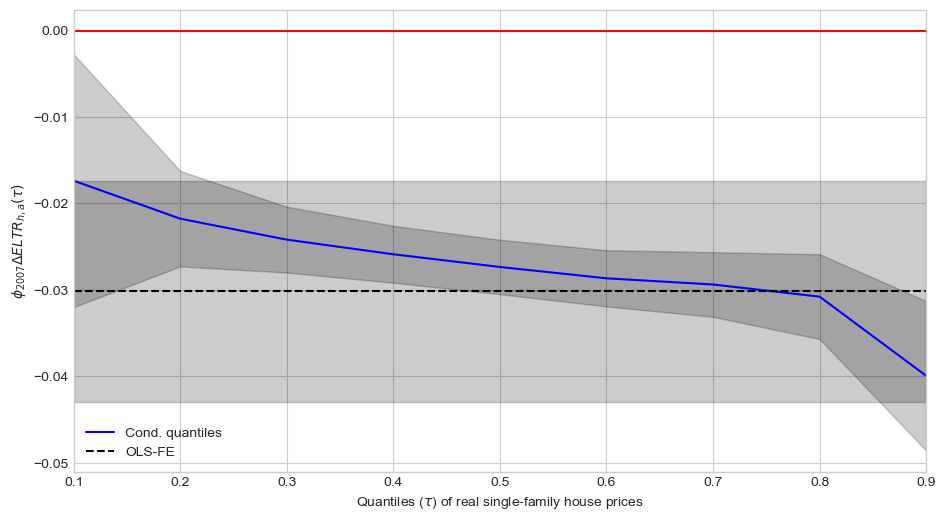

In [41]:
param_name = r'$\phi_{2007} \Delta E L T R_{h, a}(\tau)$'



n = models_fe_across.shape[0]
p1 = plt.plot(models_fe_across.q, models_fe_across.year2007_delta_tax_eff, color="blue", label="Cond. quantiles")
plt.fill_between(models_fe_across.q, models_fe_across.ub, models_fe_across.lb, alpha=0.2, color="black")
p4 = plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.legend()
plt.savefig('figs/fig_quant_v_ols.pdf', bbox_inches='tight')
plt.show()

In [42]:
models_fe_across.to_parquet('models/quantiles_fe_across.pq')

In [43]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across.fit(q=quantile,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

res_ols_fe.rsquared=None
res_ols_fe.rsquared_adj=None

list_of_models.append(res_ols_fe)

In [44]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80', 'OLS-FE'], [1,1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the area level ("old" municipalities)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()
tab

## Robustness stuff

# OLS-FE

In [45]:
formula_robust = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value + year2005_delta_tax_service + year2006_delta_tax_service + year2007_delta_tax_service + year2008_delta_tax_service"""
mod_ols_fe_robust = smf.ols(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))
res_ols_fe_robust=mod_ols_fe_robust.fit(cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']}, fe=True)
res_ols_fe_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_real_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     707.3
Date:                Fri, 28 Apr 2023   Prob (F-statistic):          8.26e-168
Time:                        10:54:28   Log-Likelihood:            -2.3925e+05
No. Observations:              374895   AIC:                         4.785e+05
Df Residuals:                  374885   BIC:                         4.786e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.8345      0.118    -41.123      0.000      -5.065      -4.604
year2005_delta_tax_eff        -0.0142      0.005     -2.606      0.009      -0.025      -0.004
year2006_delta_tax_eff        -0.0250      0.006     -3.863      0.000      -0.038      -0.012
year2007_delta_tax_eff        -0.0300      0.008     -3.897      0.000      -0.045      -0.015
year2008_delta_tax_eff        -0.0156      0.006     -2.525      0.012      -0.028      -0.003
ln_prop_value                  0.6797      0.009     78.595      0.000       0.663       0.697
year2005_delta_tax_service     0.0044      0.008      0.583      0.560      -0.010       0.019
year2006_delta_tax_service     0.0168      0.012      1.348      0.178      -0.008       0.041
year2007_delta_tax_service     0.0090      0.012      0.769      0.442      -0.014       0.032
year2008_delta_tax_service    -0.0010      0.009     -0.108      0.914      -0.018       0.016
==============================================================================
Omnibus:                   223945.738   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8299305.361
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      25.589   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

# Cond. quantiles

In [46]:
mod_quantile_fe_across_robust = smf.quantreg(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))
result_quantile_robust=mod_quantile_fe_across_robust.fit(q=0.5,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
result_quantile_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          ln_real_price   Pseudo R-squared:               0.3375
Model:                       QuantReg   Bandwidth:                     0.01473
Method:                 Least Squares   Sparsity:                       0.5088
Date:                Fri, 28 Apr 2023   No. Observations:               374895
Time:                        10:54:41   Df Residuals:                   374885
                                        Df Model:                            9
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.2398      0.011   -202.728      0.000      -2.261      -2.218
year2005_delta_tax_eff        -0.0184      0.002    -12.004      0.000      -0.021      -0.015
year2006_delta_tax_eff        -0.0235      0.002    -14.636      0.000      -0.027      -0.020
year2007_delta_tax_eff        -0.0271      0.002    -16.931      0.000      -0.030      -0.024
year2008_delta_tax_eff        -0.0192      0.002    -10.555      0.000      -0.023      -0.016
ln_prop_value                  0.8682      0.001   1069.051      0.000       0.867       0.870
year2005_delta_tax_service     0.0032      0.002      1.888      0.059      -0.000       0.007
year2006_delta_tax_service     0.0164      0.002      9.062      0.000       0.013       0.020
year2007_delta_tax_service     0.0175      0.002      9.419      0.000       0.014       0.021
year2008_delta_tax_service     0.0055      0.002      2.588      0.010       0.001       0.010
==============================================================================================
"""

In [47]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)


def fit_model(q, sig_level=0.05):
    result_quantile_robust = mod_quantile_fe_across_robust.fit(q=q, cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    return [q, result_quantile_robust.params["year2007_delta_tax_eff"]] + result_quantile_robust.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()


models_fe_across_robust = [fit_model(x) for x in quantiles]
models_fe_across_robust = pd.DataFrame(models_fe_across_robust, columns=["q", "year2007_delta_tax_eff", "lb", "ub"])
models_fe_across_robust

,q,year2007_delta_tax_eff,lb,ub
0,0.1,-0.017612,-0.032248,-0.002975
1,0.2,-0.021119,-0.026718,-0.015519
2,0.3,-0.023208,-0.027004,-0.019411
3,0.4,-0.025142,-0.028449,-0.021836
4,0.5,-0.027090,-0.030226,-0.023954
5,0.6,-0.028024,-0.031254,-0.024794
6,0.7,-0.028993,-0.032725,-0.025261
7,0.8,-0.030892,-0.035759,-0.026026
8,0.9,-0.039684,-0.048408,-0.030961


In [48]:
models_fe_across_robust.to_parquet('models/quantiles_fe_across_robust.pq')

In [137]:


shacks_ = np.linspace(-0.05, -0.1, 9)
mansions_ = np.linspace(-0.1, -0.05, 9)
equal_ = np.linspace(-0.075, -0.075, 9)

scenarios = [quantiles, shacks_, mansions_, equal_]

scenarios_df = pd.DataFrame(scenarios).T
scenarios_df.columns=['q', 'shacks', 'mansions', 'equal']
scenarios_df=scenarios_df.set_index('q')
scenarios_df

,shacks,mansions,equal
q,,,
0.1,-0.05000,-0.10000,-0.075
0.2,-0.05625,-0.09375,-0.075
0.3,-0.06250,-0.08750,-0.075
0.4,-0.06875,-0.08125,-0.075
0.5,-0.07500,-0.07500,-0.075
0.6,-0.08125,-0.06875,-0.075
0.7,-0.08750,-0.06250,-0.075
0.8,-0.09375,-0.05625,-0.075
0.9,-0.10000,-0.05000,-0.075


In [136]:
from scipy.interpolate import make_interp_spline

In [147]:
shacks_

array([-0.05   , -0.05625, -0.0625 , -0.06875, -0.075  , -0.08125,
       -0.0875 , -0.09375, -0.1    ])

In [183]:
shacks_=np.array([-0.05   , -0.055, -0.056 , -0.057, -0.061  , -0.063,
       -0.070 , -0.074, -0.078   ])

In [184]:
X_Y_Spline = make_interp_spline(quantiles, shacks_)

In [185]:
quantiles

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

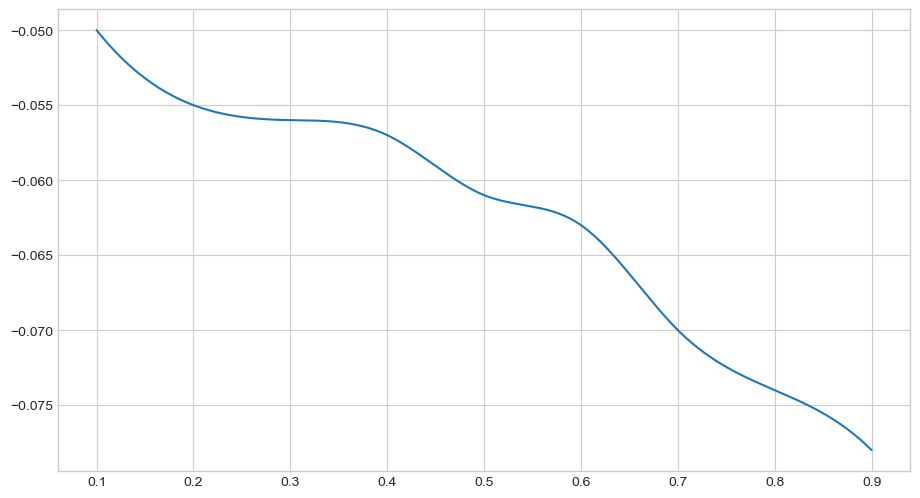

In [186]:
temp=np.linspace(quantiles.min(), quantiles.max(), 500)
new=X_Y_Spline(temp)
plt.plot(temp, new)

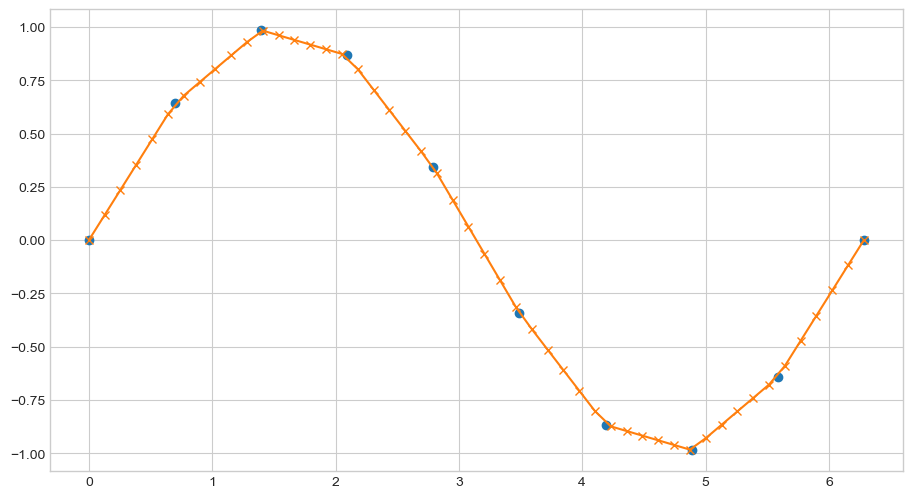

In [119]:
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)
xvals = np.linspace(0, 2*np.pi, 50)
yinterp = np.interp(xvals, x, y)
plt.plot(x, y, 'o')
plt.plot(xvals, yinterp, '-x')

(-0.11, 0.01)

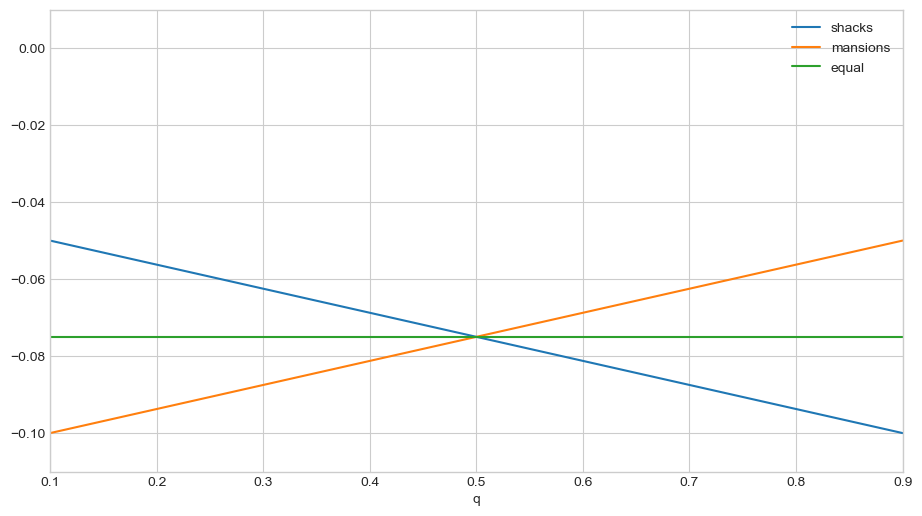

In [63]:
plot=scenarios_df.plot()
plot.set_xlim(0.1, 0.9)
plot.set_ylim(-0.11, 0.01)

# Robustness stuff

In [190]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across_robust.fit(q=quantile,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

# res_ols_fe.rsquared=None
# res_ols_fe.rsquared_adj=None

# list_of_models.append(res_ols_fe)

In [193]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80'], [1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the area level ("old" municipalities)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results_robust.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()
tab